# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.



In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from pyspark.sql import Window
from pyspark.sql import SparkSession

from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg, substring, col, when, min, max, sum, split
from pyspark.sql.functions import udf, count, countDistinct, rand, struct, isnan, isnull, dayofmonth 
from pyspark.sql.functions import month, datediff, to_date, lit, current_date

from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType, StringType

from pyspark.ml.feature import Normalizer, StandardScaler
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.utils import resample



%matplotlib inline

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_1") \
    .getOrCreate()

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

## Exploring data and features

In [4]:
# Exploring data structure
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [6]:
# Number of observations
df.count()

286500

## Cleaning the dataset

In [7]:
# Removing duplicates in UserID
df.select("userId").dropDuplicates().count() 

226

In [8]:
# Removing empty values and strings
df_clean = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df_clean = df_clean.filter(df_clean['userId'] != '')

In [9]:
df_clean.head(2) 

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

### Transforming time features

In [10]:
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
df_clean = df_clean.withColumn("registration_date", get_date(df_clean.registration))

In [11]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%H"))
df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

### Extracting Location

In [12]:
get_location=udf(lambda x:x[-2:])
df_clean = df_clean.withColumn("location_state", get_location(df_clean.location))

In [13]:
df_clean.select("location_state").distinct().show()

+--------------+
|location_state|
+--------------+
|            AZ|
|            SC|
|            LA|
|            NJ|
|            OR|
|            VA|
|            KY|
|            NH|
|            MI|
|            NV|
|            WI|
|            ID|
|            CA|
|            CT|
|            MT|
|            NC|
|            MD|
|            MO|
|            IL|
|            WA|
+--------------+
only showing top 20 rows



# Exploratory Data Analysis


### Defining Churn

Below I will define the churn variable  based on the user ID and cancellation confirmation feature in the dataset. 

In [14]:
df_clean.createOrReplaceTempView('user_log_table')

# data with churned users
churn = spark.sql('SELECT DISTINCT userId, 1 as churn FROM user_log_table WHERE Page = "Cancellation Confirmation"')

In [15]:
# data with other users
no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn FROM user_log_table \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM user_log_table WHERE Page = "Cancellation Confirmation")')

In [16]:
# Creating a combined dataset of churned users
churn_combined = churn.union(no_churn)
churn_combined.createOrReplaceTempView('churn_nochurn')
churn_combined = spark.sql('SELECT * FROM churn_nochurn ORDER BY RAND()')
churn_combined.count()

225

In [17]:
# Combining dataframes
churn_df = df_clean.join(churn_combined, on='userId')

In [18]:
churn_df.select(['userId', 'churn']).dropDuplicates().show(20)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [19]:
churn_df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



## Data Exploration

Below I explore the data and see whteher there are connections between different variables in the dataset. I also visualise some results. 

### 1. Churn and Time

First I will explore whethere there is connection between time and churn variable. 

In [20]:
churn_df.select("hour").distinct().show()

+----+
|hour|
+----+
|  07|
|  15|
|  11|
|  01|
|  22|
|  16|
|  18|
|  00|
|  17|
|  09|
|  05|
|  19|
|  23|
|  08|
|  03|
|  02|
|  06|
|  20|
|  10|
|  12|
+----+
only showing top 20 rows



In [21]:
churn_df.select("registration_date").distinct().show()

+-----------------+
|registration_date|
+-----------------+
|       2018-08-23|
|       2018-06-22|
|       2018-08-24|
|       2018-09-27|
|       2018-11-26|
|       2018-09-15|
|       2018-08-02|
|       2018-08-04|
|       2018-07-28|
|       2018-08-29|
|       2018-08-09|
|       2018-07-29|
|       2018-09-12|
|       2018-06-25|
|       2018-06-09|
|       2018-08-30|
|       2018-09-29|
|       2018-06-30|
|       2018-08-13|
|       2018-08-14|
+-----------------+
only showing top 20 rows



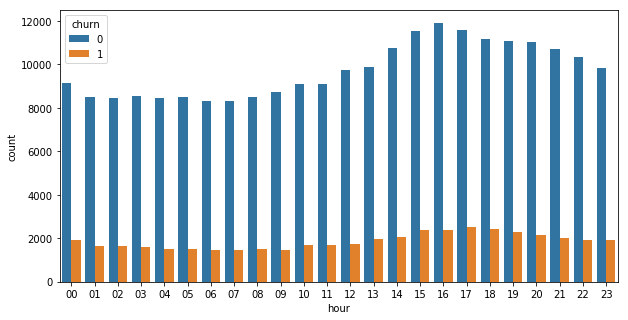

In [22]:
plt.figure(figsize=(10,5))
df_hour=churn_df.groupby(["churn", "hour"]).count().sort("churn").toPandas()
sns.barplot(x='hour', y='count', hue='churn', data=df_hour)

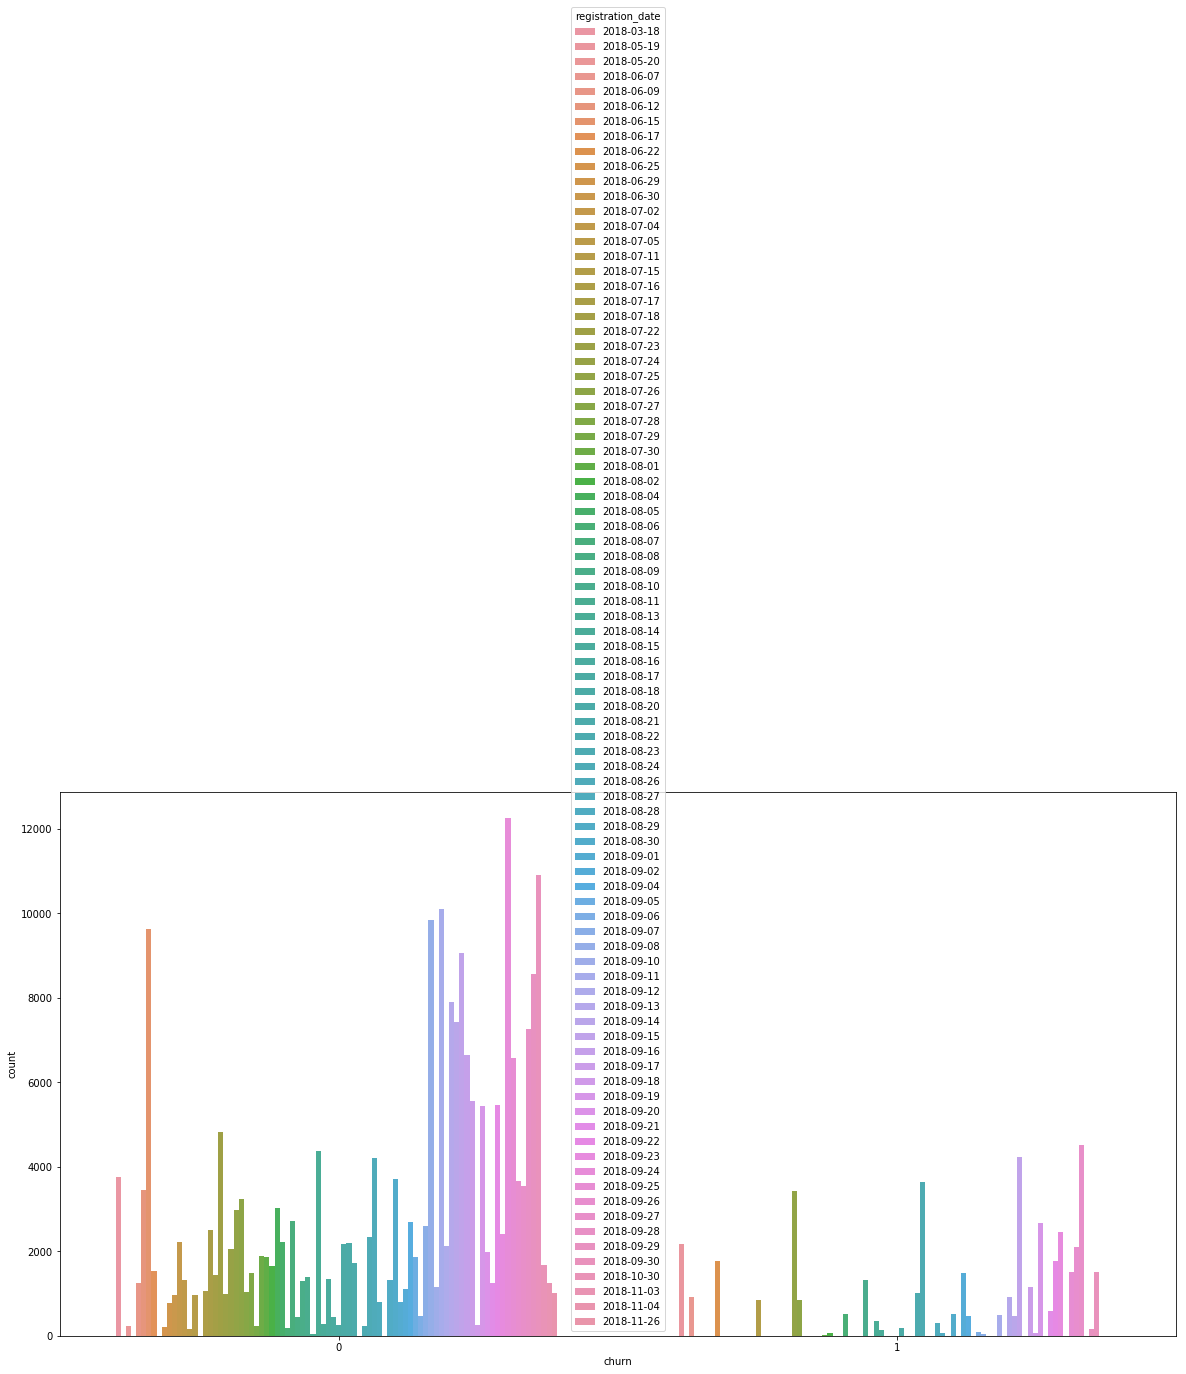

In [23]:
plt.figure(figsize=(20,10))
df_registration_date=churn_df.groupby(["registration_date", "churn"]).count().sort("registration_date").toPandas()
sns.barplot(x='churn', y='count', hue='registration_date', data=df_registration_date);

I don´t see any particularly strong connection between time variables and churn. 

### 2. Churn and the level of subscription

Next potential connection I will visualise is the relation between churn and the level of subscription. There are two levels of subscription: free and paid. I will verify whether churn rates are higher at the paid level or not. 

In [24]:
churn_df.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



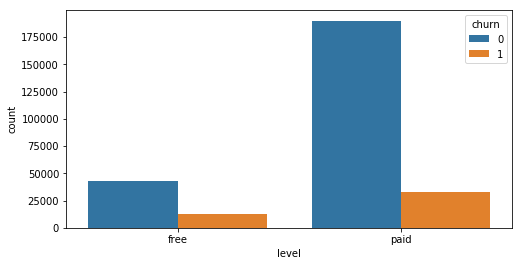

In [25]:
plt.figure(figsize=(8,4))
df_level=churn_df.groupby(["churn", "level"]).count().sort("churn").toPandas()
sns.barplot(x='level', y='count', hue='churn', data=df_level)

Based on this visualisation alone we can see that free users churn slightly more than paid users.

### 4. Churn and user location

In this step I will visualise the connection between churn and geographical location of users. 

In [26]:
churn_df.select("location_state").distinct().count()

39

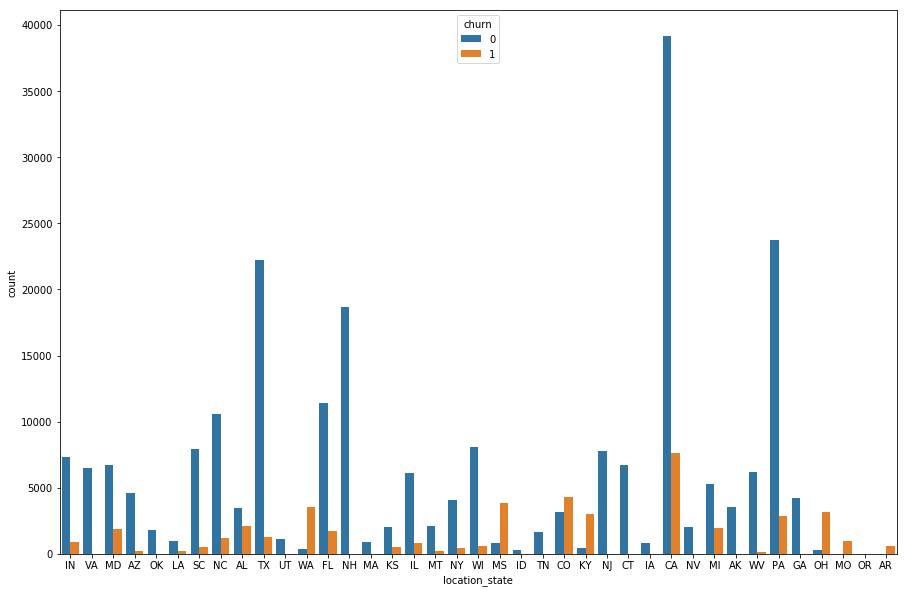

In [27]:
plt.figure(figsize=(15,10))
df_location=churn_df.groupby(["location_state", "churn"]).count().sort("churn").toPandas()
sns.barplot(x='location_state', y='count', hue='churn', data=df_location);

There seem to be a dependency between location and churn rate. However, based on this graph alone, it is impossible to say whethere there are other factors influencing churn rates in particular states. 

# Feature Engineering

I the following step I recreate the dataset with numeric features and create some features for the model.

### 1. Total songs per user

In [28]:
# Number of songs per user
song_per_user = churn_df \
                  .select("userId","song")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","song_per_user")
song_per_user.describe().show()

+-------+------------------+-----------------+
|summary|            userId|    song_per_user|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



### 2. Gender

In [29]:
# Gender
gender_num = churn_df\
           .select('userId','gender')\
           .dropDuplicates() \
           .replace(['M','F'],['0','1'],'gender')\
           .select('userId',col('gender').cast('int'))\
           .withColumnRenamed('gender', 'gender_num') 
gender_num.describe().show()

+-------+------------------+------------------+
|summary|            userId|        gender_num|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.4622222222222222|
| stddev|105396.47791907164|0.4996824388374478|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



### 3. Thumbs up per user

In [30]:
# Thumbs up
thumbs_up = churn_df \
             .select('userID','page') \
             .where(churn_df.page == 'Thumbs Up') \
             .groupBy('userID') \
             .count() \
             .withColumnRenamed('count', 'thumbs_up') 
thumbs_up.describe().show()

+-------+------------------+-----------------+
|summary|            userID|        thumbs_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



### 4. Thums down per user

In [31]:
# Thumbs down
thumbs_down = churn_df \
                 .select('userID','page') \
                 .where(churn_df.page == 'Thumbs Down') \
                 .groupBy('userID') \
                 .count() \
                 .withColumnRenamed('count', 'thumbs_down')
thumbs_down.describe().show()

+-------+------------------+------------------+
|summary|            userID|       thumbs_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



### 5. Listening time

In [32]:
# Listening time
listening_time = churn_df \
            .select('userId','length') \
            .groupby(['userId']) \
            .sum() \
            .withColumnRenamed('sum(length)','listening_time')

listening_time.describe().show()

+-------+------------------+------------------+
|summary|            userId|    listening_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



### 6. Level

In [33]:
level_num = churn_df\
         .select('userId','level')\
         .replace(['free','paid'],['0','1'],'level')\
         .select('userId',col('level').cast('int'))\
         .withColumnRenamed('level', 'level_num') 
level_num.describe().show()

+-------+------------------+-------------------+
|summary|            userId|          level_num|
+-------+------------------+-------------------+
|  count|            278154|             278154|
|   mean| 59682.02278593872| 0.7996757192059075|
| stddev|109091.94999910559|0.40024372479844644|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



### 7. Changing name from churn to label

In [34]:
label = churn_df \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [35]:
# Joining data set 
data = song_per_user.join(gender_num,'userID','outer') \
          .join(thumbs_up,'userID','outer') \
          .join(thumbs_down, 'userID','outer') \
          .join(listening_time,'userID','outer') \
          .join(level_num,'userID','outer') \
          .join(label,'userID','outer') \
          .drop('userID') \
          .fillna(0)

data.show(5)

+-------------+----------+---------+-----------+-----------------+---------+-----+
|song_per_user|gender_num|thumbs_up|thumbs_down|   listening_time|level_num|label|
+-------------+----------+---------+-----------+-----------------+---------+-----+
|          381|         1|       17|          5|66940.89735000003|        0|    0|
|          381|         1|       17|          5|66940.89735000003|        0|    0|
|          381|         1|       17|          5|66940.89735000003|        0|    0|
|          381|         1|       17|          5|66940.89735000003|        0|    0|
|          381|         1|       17|          5|66940.89735000003|        0|    0|
+-------------+----------+---------+-----------+-----------------+---------+-----+
only showing top 5 rows



In [36]:
data.select("label").distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



# Modeling

### Feature Scaling and Transformation

As a first step I vectorize the features

In [37]:
# Vector assembler
cols = ['song_per_user', 'gender_num', 'thumbs_up', 'thumbs_down','level_num','listening_time']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)

The features also need scaling in order to be processed by the algorithms. Here I standardize the features.

In [38]:
# Standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

## Model Selection

### Implementation

For the purpose of this project, as a first step, I decided to implement three algorithms without any parameter tunig.

In the considerations, which algorithms to choose I had to take into account the fact, that not all algorithms are supported by the Spark framework.

Another issue is defining, what kind of algorithm can we use in order to answer the question about customer churn. 

Customer churn feature is a binary one with basically two values: churn and no-churn. Therefore our question is a classification question and thus we need to implement a classification algorithm. 

Spark supports folowing classification algorithms:

- Logistic Regression
- Random Forests
- Gradient Boosted Trees
- Support Vector Machines
- Naive Bayes

For the first step of my modeling strategy I decided to implement: logistic regression, random forests and gradient boosted trees.

Logistic regresion as well Naive Bayes are often used as a first try algorithms. For this project I have chosen logistic regression as it is relatively easy to implement and works fast with the data at hand. Logistic regression is also mor robust to overfitting than radnom forest and gradient boosting.

Further, I implement ensemble techniques: random forest and gradient boosting. Both random forest as well as gardient boosting are based on the weak learners: decision trees. Although they both are based on the decision trees they utilise them in quite opposite ways: whereas random forest  is training the decision trees in parallel, gradient boosting algorithm proceeds sequential. For more information on this topic see: Lujing Chen in Medium (https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725).


Gradient boosting is known for good performance in unbalanced datasets. Therefore it is resonable to assume, that it will perform best with our small sample in Sparkify datasubset. (Source: Abolfazl Ravanshad for Medium https://medium.com/@aravanshad/gradient-boosting-versus-random-forest-cfa3fa8f0d80). 

On the other hand random forests are known for good handling of large amounts of data. This could become handy later on in our project, when the algorithm is tested on the whole set of the data.

The issue with both algorithms (random forest and gradient boosting) is their frequent overfitting. That is the reason I introduce logistic regression as a comparison to the two. Logistic regression tends to not overfitt. However it has opposite issues with high bias.

With the selection of modeling strategy I also had to take into account its computation time. Form my experience SVM algorithm is very time consuming. I assume that the three chosen algorithms perform best with regard to computation time. 

My overall approach is following:

- first I run all three algorithms as baseline models without any further hyperparameter tuning in order to see which one is delivering best results as measured by the F1 score. This strategy enables me to test models without loosing too much time with computation. 

- second, based on the results from the first try, I decide which algorithm to use and subsequently implement it with parameter tuning (grid search). 

It is important to bear in mind, that the dataset at hand is not balanced. Specifically, it contains much less churned users than not churned. This can be especially problematic in the testing part of the sample(which is smaller).

For this reasion I use F1 score instead of relying on accuracy score as metrics of choice to asses the perofmance of each baseline model. 

### Train and Validation Set

In [39]:
# Splitting data into train and validation set
rest, validation = data.randomSplit([0.8, 0.2], seed=42)

Below I try the three baseline models

### Logistic Regression

In [40]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

In [41]:
f_score = MulticlassClassificationEvaluator(metricName='f1')

In [42]:
lr_train = lr.fit(rest)
lr_test = lr_train.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

print('Accuracy:')
print(evaluator.evaluate(lr_test,{evaluator.metricName: 'accuracy'}))
print('F-1 score:')
print(evaluator.evaluate(lr_test, {evaluator.metricName: 'f1'}))


Accuracy:
0.8368801987684995
F-1 score:
0.7625630322111933


### Random Forest

In [43]:
rf = RandomForestClassifier()

In [44]:
f_score=MulticlassClassificationEvaluator(metricName='f1')

In [45]:
rf_train = rf.fit(rest)
rf_test = rf_train.transform(validation)


evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy:')
print(evaluator.evaluate(rf_test,{evaluator.metricName: 'accuracy'}))
print('F-1 score:')
print(evaluator.evaluate(rf_test, {evaluator.metricName: 'f1'}))

Accuracy:
0.878002232544741
F-1 score:
0.8457104279069035


### Gradient Boosting

In [46]:
gb = GBTClassifier()

In [47]:
f_score=MulticlassClassificationEvaluator(metricName='f1')

In [48]:
gb_train = gb.fit(rest)
gb_test = gb_train.transform(validation)
    

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

print('Accuracy')
print(evaluator.evaluate(gb_test,{evaluator.metricName: 'accuracy'}))
print('F-1 score')
print(evaluator.evaluate(gb_test, {evaluator.metricName: 'f1'}))

Accuracy
0.9907457419610385
F-1 score
0.9906360976378528


## Preliminary Results and Refinement

Overall, the results of the baseline specifications look encouraging. Especially random forest and gardient boosting scored very well on the F1 metrics. 

Not surprisingly logistic regression had the lowest F1 score. This is due to the fact, that (as a linear specification) regression results have more bias but also overfit less than the decision tree based algorithms.

Nevertheless, I will proceed further with gradient boosting algorithm. Its scores on the first run were the best. Despite overfitting I expect it to generally perform better on the entire Sparkify dataset. 

In the next stage I will therefore improve on the gradient boosting specification. 

I will use grid search to find best hyperparameters. Additionally I splitt the sample of the data evenly 50-50 in order to account for the small number of churned customers in the test sample. 


### Gradient Boosting

In [49]:
train, test = data.randomSplit([0.7, 0.3], seed=42) # different splitting of the dataset

In [50]:
gb_tuned = GBTClassifier()

In [51]:
# Tuning the hyperparameter
paramGrid = ParamGridBuilder()\
       .addGrid(gb_tuned.maxIter,[5,10])\
       .addGrid(gb_tuned.maxDepth,[4,12]) \
       .build()


crossval_gbt = CrossValidator(estimator=gb_tuned,
                           evaluator=f_score,
                           estimatorParamMaps=paramGrid,
                           numFolds=3)

In [52]:
gb_train = gb_tuned.fit(train)
gb_test = gb_train.transform(test)
    

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Gradient Boosting Results')
print('Accuracy')
print(evaluator.evaluate(gb_test,{evaluator.metricName: 'accuracy'}))
print('F-1 score')
print(evaluator.evaluate(gb_test, {evaluator.metricName: 'f1'}))



Gradient Boosting Results
Accuracy
0.9876918273733759
F-1 score
0.9874946609715828


## Feature Importance

In [53]:
gb_train.featureImportances

SparseVector(6, {0: 0.3607, 1: 0.0165, 2: 0.2454, 3: 0.2453, 4: 0.0044, 5: 0.1276})

In [54]:
importances = [0.2823, 0.0366, 0.2839, 0.2563, 0.0191, 0.1219]
features = ['song_per_user', 'gender_num', 'thumbs_up', 'thumbs_down','level_num','listening_time']

Text(0.5,1,'Feature Importances')

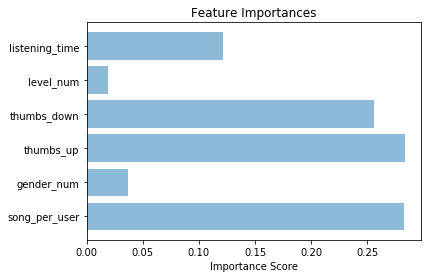

In [55]:
feat = np.arange(len(features))
 
plt.barh(feat, importances, align='center', alpha=0.5)
plt.yticks(feat, features)
plt.xlabel('Importance Score')
plt.title('Feature Importances')

# Summary 

In this project first I introduced three baseline algorithms in order to predict customer churn rates of a Sparkify app. The best performing one was the gardient boosting algorithm with an Accuracy of over 99% and F1 score of 99%. 

The results suggest a major overifitting caused most probably by the small and unbalanced sample of the data. 

Second, based on its performance I proceeded with gradient boosting algorithm. Additionally in the second step I applied hyperparameter tuning via grid search.  The reason for this strategy is the assumption, that gradient bosting will, despite overfitting, perform best on the wohle dataset. 

After the second run of the garadient boosting with hyperparameter tuned, the results are similar to those from the baseline model. The F1 score remained  very high at 99%. As a next step we should test gradient boosting on the entire dataset.

Furthermore, I also examined the most important factors for the churn rate as it is displayed in the feature importance section. The most important factors in customer churn seem to be: the number of songs played per user, user engagement as represented by the thumbs up/down feature and overall listening time.


# Reflection and Improvements

Overall, one of the most demanding task in the project was gaining of a throughout understanding of the data at hand. The high number of features and the interactions between users and the app had to be entangled and quantified in order to be processed by algorithms. 

The easiest way to improve the results of this analysis would be a wider graphical visualisation of the connections between various features. This could improve our understanding of the data. 

From the feature importance section we can also see, that factors most responsible for the churn rate are probably correlated with each other. A further research strategy could therfore design a statistical regression analysis with some features and see, which factors are statistically significant for predicting the churn rate. Here I could also introduce geographical location as a dummy variable.

Additionally a further viable stategy would be to sample many smaller datasets from the large dataset and process them without using Spark. In this case we could use wider range of algorithms that are currently not supported by Spark. 